In [1]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Docs/Spam_SMS.csv')

df

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5574 non-null   object
 1   Message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df['Class'].value_counts()

,count
Class,
ham,4827
spam,747


In [5]:
def preprocess_text(text):
    # Normalization
    text = str(text)
    text = text.lower()
    # removing punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Removes newlines
    text = re.sub("\n", '', text)
    # digits
    text = re.sub("\d", '', text)

    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Rejoin tokens into a single string
    processed_text = ' '.join(tokens)
    return processed_text

df['Message_cleaned'] = df['Message'].apply(preprocess_text)

df['Message_cleaned']

,Message_cleaned
0,go jurong point crazi avail bugi n great world...
1,ok lar joke wif u oni
2,free entri wkli comp win fa cup final tkt st m...
3,u dun say earli hor u c alreadi say
4,nah dont think goe usf live around though
...,...
5569,nd time tri contact u u pound prize claim easi...
5570,ü b go esplanad fr home
5571,piti mood soani suggest
5572,guy bitch act like id interest buy someth els ...


In [6]:
#for model-building
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

In [7]:
models = []

#Naive Bayes
models.append(('Naive Bayes', GaussianNB()))
models.append(('Complement Naive Bayes', ComplementNB()))
models.append(('Multinomial Naive Bayes',MultinomialNB()))

#Decision Trees
models.append(('CART with gini', DecisionTreeClassifier(criterion='gini')))
models.append(('CART with entropy', DecisionTreeClassifier(criterion='entropy')))

#MLP
models.append(('MLP Adam TANH, 5x2', MLPClassifier(solver='adam', hidden_layer_sizes= (5,2), max_iter=500, activation = 'tanh')))
models.append(('MLP Adam Logistic, 5x2', MLPClassifier(solver='adam', hidden_layer_sizes= (5,2), max_iter=500, activation = 'logistic')))
models.append(('MLP Adam Identity, 5x2', MLPClassifier(solver='adam', hidden_layer_sizes= (5,2), max_iter=500, activation = 'identity')))

#SVM
models.append(('SVM RBF 3', SVC(kernel='rbf', C=0.5, gamma='auto', probability=True)))
models.append(('SVM Linear 2', SVC(kernel='linear', C=0.5, probability=True)))
models.append(('SVM Poly 1', SVC(kernel='poly', degree=1, C=1.0,  probability=True)))
models.append(('SVM Poly 2', SVC(kernel='poly', degree=1, C=0.05,  probability=True)))
models.append(('SVM Poly 3', SVC(kernel='poly', degree=3, C=0.7,  probability=True)))
models.append(('SVM Poly 4', SVC(kernel='poly', degree=3, C=0.9,  probability=True)))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['Message_cleaned'],df['Class'],test_size=0.2,shuffle=True)

In [9]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [10]:
import math

# Trainning the models for evaluation, further trainning wil be done individually
# This trainning is for evaluating the performance of each model to unsen data and different
# combinations of the
results=[]
names=[]

for name,model in models:
  print(f'\nEntrenando el modelo {name}...')
  kfold=KFold(n_splits=10,shuffle=True)
  try:
    cv_result=cross_val_score(model,X_train_vectors_tfidf,y_train,cv=kfold,scoring='accuracy')
  except ValueError:
    cv_result=cross_val_score(model,X_train_vectors_tfidf.toarray(),y_train,cv=kfold,scoring='accuracy')

  names.append(name)
  results.append(cv_result)




Entrenando el modelo Naive Bayes...

Entrenando el modelo Complement Naive Bayes...

Entrenando el modelo Multinomial Naive Bayes...

Entrenando el modelo CART with gini...

Entrenando el modelo CART with entropy...

Entrenando el modelo MLP Adam TANH, 5x2...

Entrenando el modelo MLP Adam Logistic, 5x2...

Entrenando el modelo MLP Adam Identity, 5x2...

Entrenando el modelo SVM RBF 3...

Entrenando el modelo SVM Linear 2...

Entrenando el modelo SVM Poly 1...

Entrenando el modelo SVM Poly 2...

Entrenando el modelo SVM Poly 3...

Entrenando el modelo SVM Poly 4...


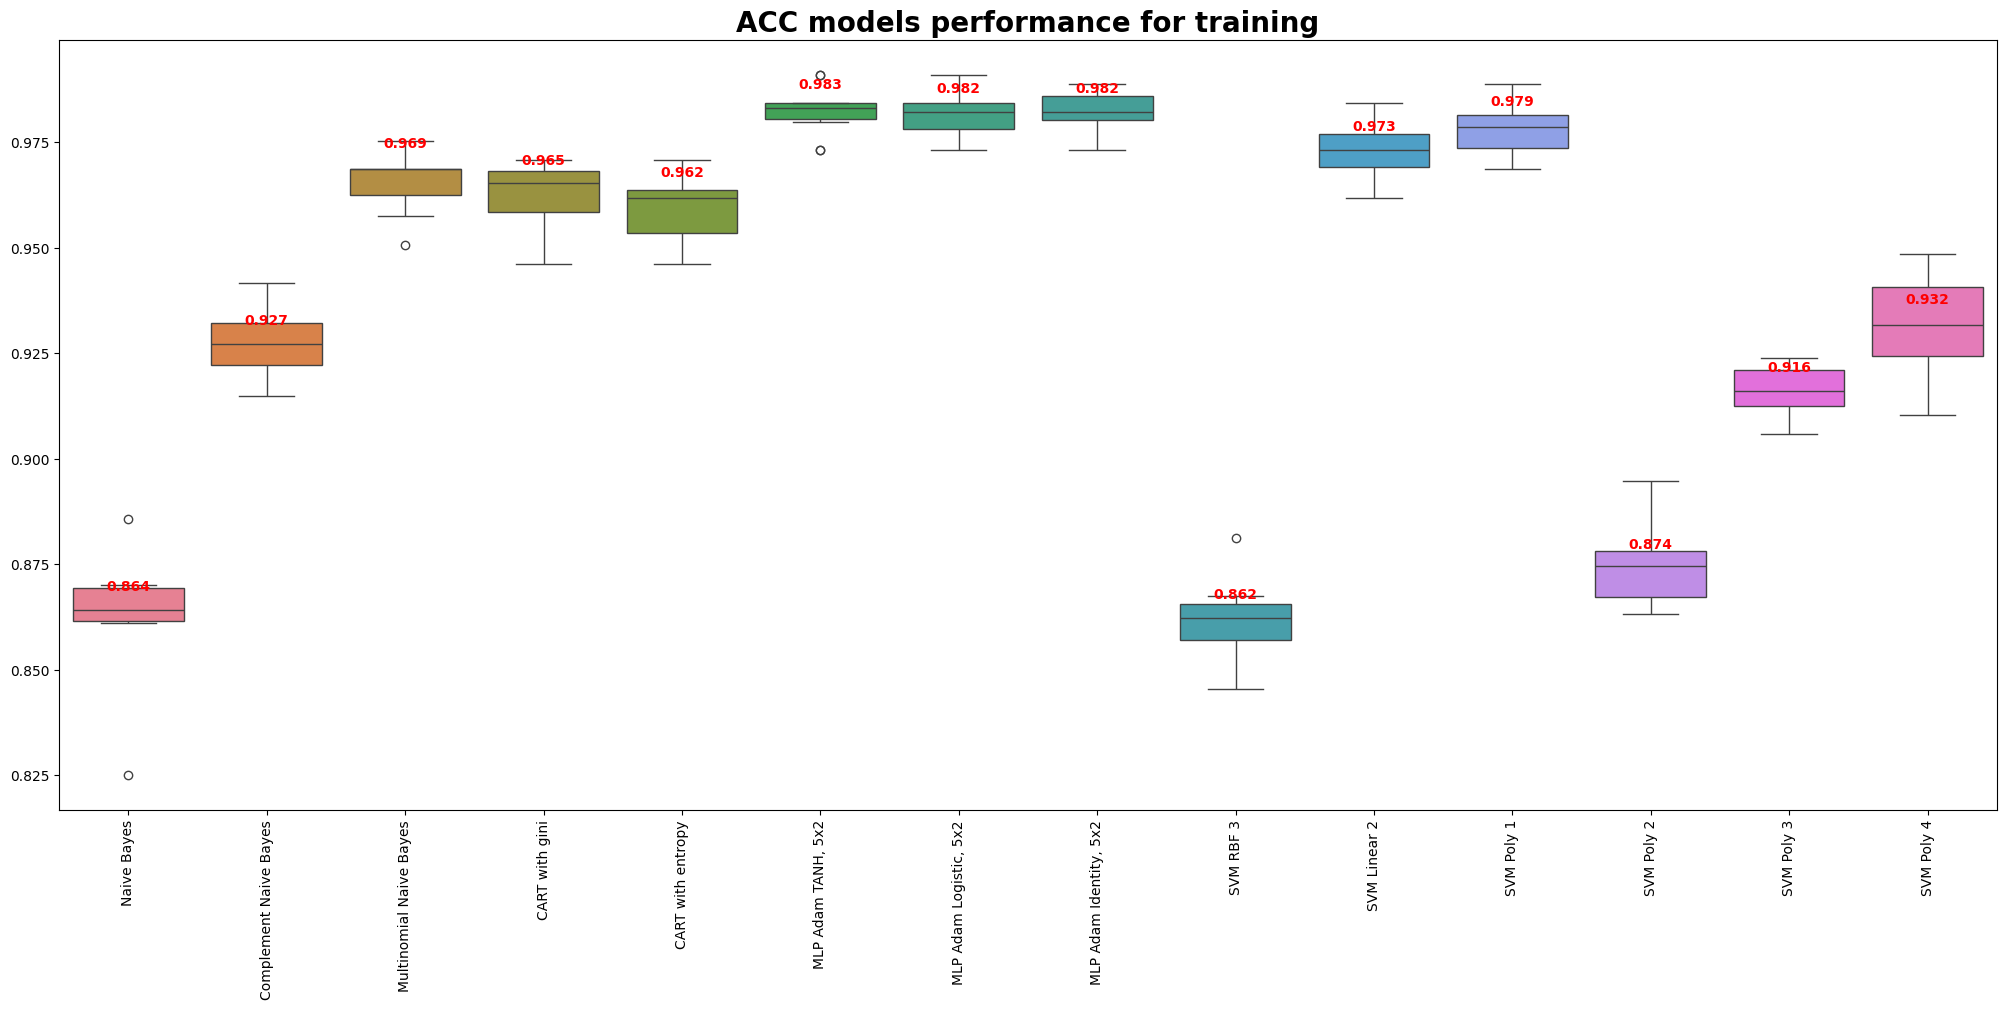

In [11]:
#obtaining the medians
import statistics
import warnings
warnings.filterwarnings('ignore')


medians = []
for i in range(len(results)):
  medians.append(round(statistics.median(results[i]),3))

fig,ax=plt.subplots(figsize=(25,10))
sns.boxplot(data=results,ax=ax)
ax.set_xticklabels(names)
vertical_offset=statistics.median(medians)*0.005
for xtick in ax.get_xticks():
  ax.text(xtick,medians[xtick]+vertical_offset,medians[xtick],horizontalalignment='center',color='red', weight='semibold')
plt.title('ACC models performance for training',fontsize=20,fontweight='bold')
plt.xticks(rotation='vertical')
plt.show()

Evaluating Naive Bayes with test data
---------------------------------------


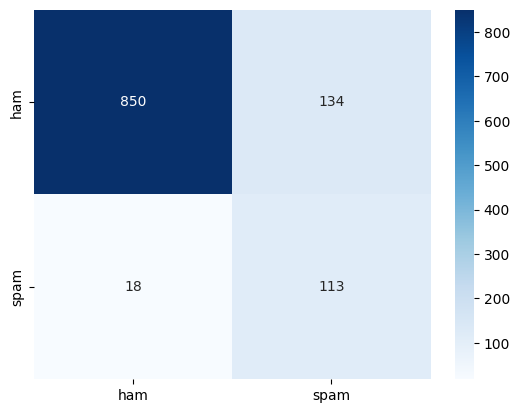

ACC: 0.863677130044843
Misclassification Rate: 0.13632286995515694
Recall: 0.8625954198473282
Precision: 0.4574898785425101




Evaluating Complement Naive Bayes with test data
---------------------------------------


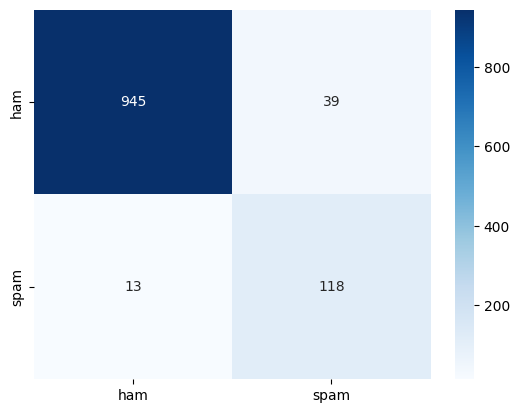

ACC: 0.9533632286995516
Misclassification Rate: 0.04663677130044843
Recall: 0.9007633587786259
Precision: 0.7515923566878981




Evaluating Multinomial Naive Bayes with test data
---------------------------------------


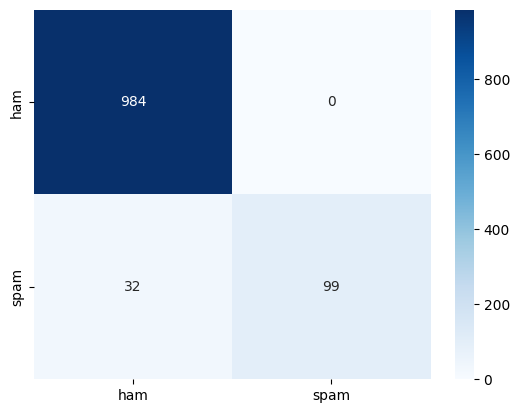

ACC: 0.9713004484304932
Misclassification Rate: 0.028699551569506727
Recall: 0.7557251908396947
Precision: 1.0




Evaluating CART with gini with test data
---------------------------------------


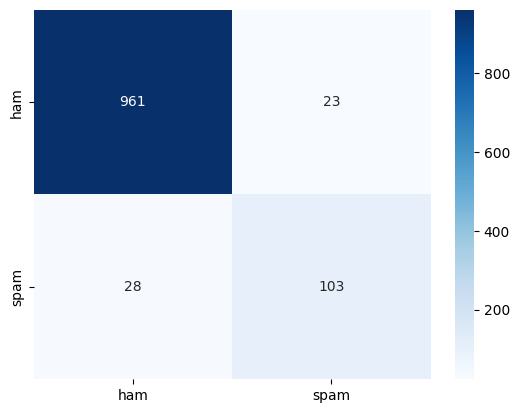

ACC: 0.9542600896860987
Misclassification Rate: 0.045739910313901344
Recall: 0.7862595419847328
Precision: 0.8174603174603174




Evaluating CART with entropy with test data
---------------------------------------


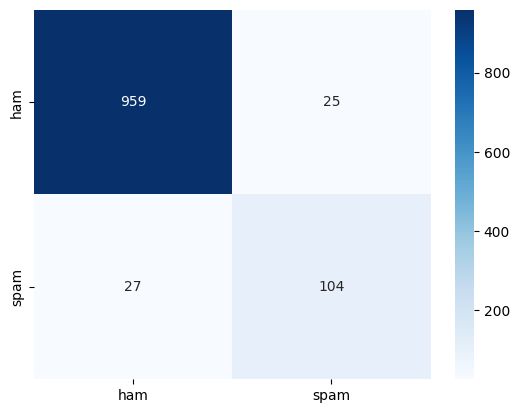

ACC: 0.9533632286995516
Misclassification Rate: 0.04663677130044843
Recall: 0.7938931297709924
Precision: 0.8062015503875969




Evaluating MLP Adam TANH, 5x2 with test data
---------------------------------------


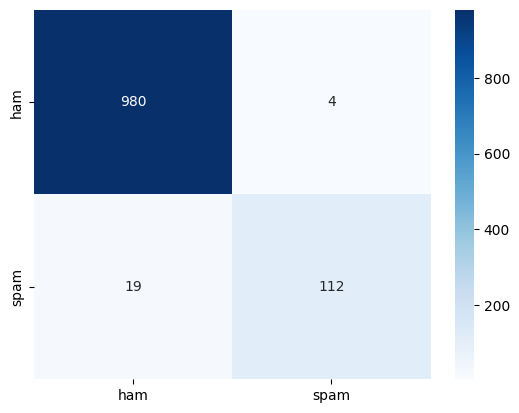

ACC: 0.979372197309417
Misclassification Rate: 0.02062780269058296
Recall: 0.8549618320610687
Precision: 0.9655172413793104




Evaluating MLP Adam Logistic, 5x2 with test data
---------------------------------------


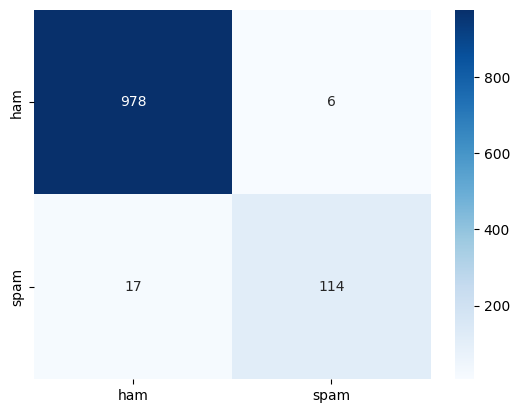

ACC: 0.979372197309417
Misclassification Rate: 0.02062780269058296
Recall: 0.8702290076335878
Precision: 0.95




Evaluating MLP Adam Identity, 5x2 with test data
---------------------------------------


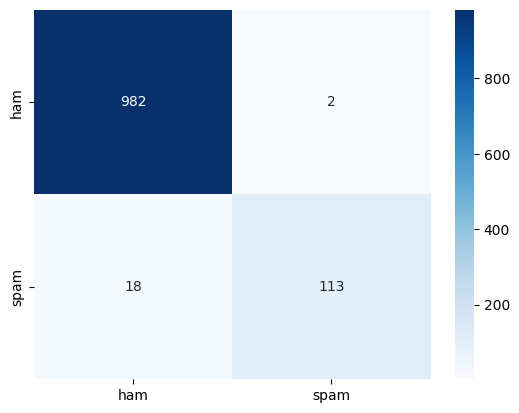

ACC: 0.9820627802690582
Misclassification Rate: 0.017937219730941704
Recall: 0.8625954198473282
Precision: 0.9826086956521739




Evaluating SVM RBF 3 with test data
---------------------------------------


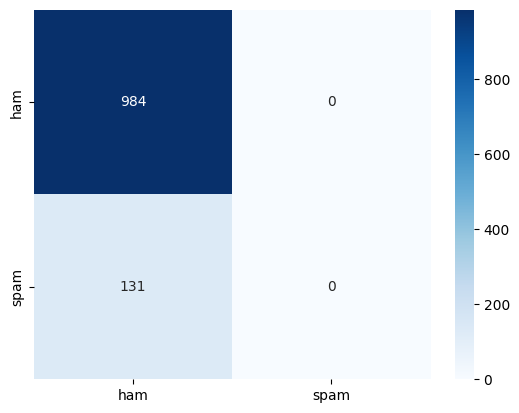

ACC: 0.8825112107623319
Misclassification Rate: 0.11748878923766816
Recall: 0.0
Precision: nan


<ipython-input-12-28babde14501>:44: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Precision: {TP / (TP + FP)}')






Evaluating SVM Linear 2 with test data
---------------------------------------


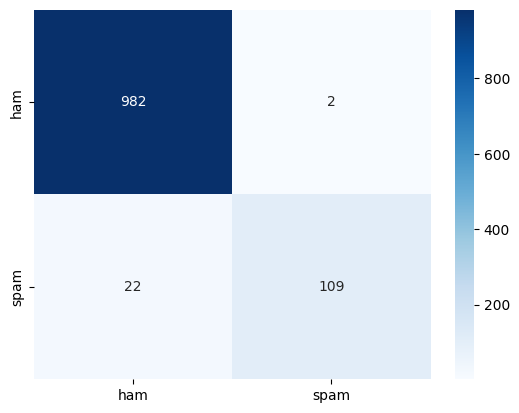

ACC: 0.97847533632287
Misclassification Rate: 0.021524663677130046
Recall: 0.8320610687022901
Precision: 0.9819819819819819




Evaluating SVM Poly 1 with test data
---------------------------------------


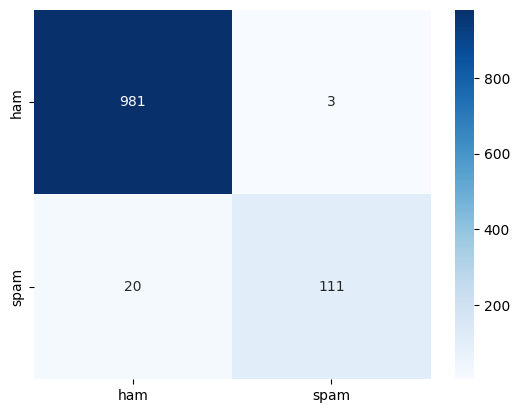

ACC: 0.979372197309417
Misclassification Rate: 0.02062780269058296
Recall: 0.8473282442748091
Precision: 0.9736842105263158




Evaluating SVM Poly 2 with test data
---------------------------------------


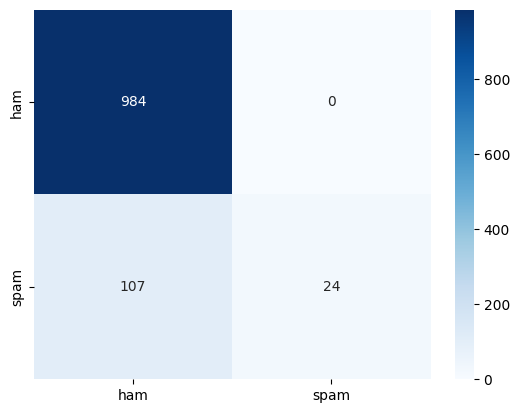

ACC: 0.9040358744394619
Misclassification Rate: 0.09596412556053811
Recall: 0.183206106870229
Precision: 1.0




Evaluating SVM Poly 3 with test data
---------------------------------------


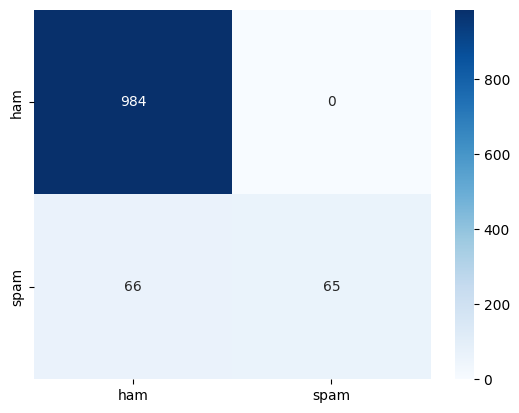

ACC: 0.9408071748878923
Misclassification Rate: 0.059192825112107626
Recall: 0.4961832061068702
Precision: 1.0




Evaluating SVM Poly 4 with test data
---------------------------------------


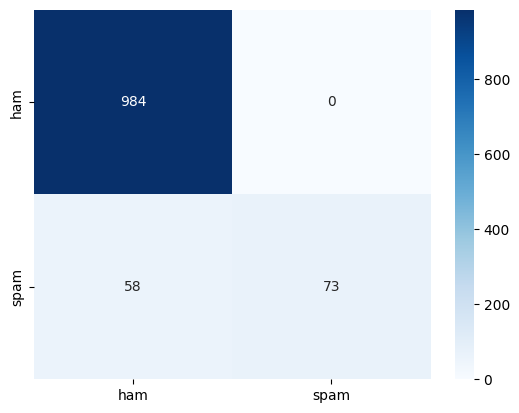

ACC: 0.9479820627802691
Misclassification Rate: 0.05201793721973094
Recall: 0.5572519083969466
Precision: 1.0






In [12]:
warnings.simplefilter('always')

label = ["ham", "spam"]
FPR = [] #false positives rates vector
TPR = [] #true positives rates vector
TRESH = [] #threshold rates vector
y_scores = [] #prediction in each point

for name,model in models:
  try:
    model.fit(X_train_vectors_tfidf,y_train)
  except (TypeError, ValueError):
    model.fit(X_train_vectors_tfidf.toarray(),y_train)
  try:
    y_predict = model.predict(X_test_vectors_tfidf)
  except (TypeError, ValueError):
    y_predict = model.predict(X_test_vectors_tfidf.toarray())

  print(f'Evaluating {name} with test data')
  print('---------------------------------------')
  #confusion matrix
  confusion = confusion_matrix(y_test, y_predict)
  sns.heatmap(confusion, annot=True, xticklabels=label, yticklabels=label, fmt='', cmap='Blues')
  plt.show()
  #taking the important values from confusion matrix
  TP = confusion[1, 1]  #True Positives (TP)
  TN = confusion[0, 0]  #True Negatives (TN)
  FP = confusion[0, 1]  #False Positives (FP) a "Type I error"
  FN = confusion[1, 0]  #False Negatives (FN) a "Type II error"

  #Classification Accuracy: Overall, how often is the classifier correct?
  print(f'ACC: {(TP + TN) / (TP + TN + FP + FN)}')
  #print(f'ACC: {accuracy_score(y_test, y_predict)}')

  #Classification Error: Overall, how often is the classifier incorrect?
  print(f'Misclassification Rate: {(FP + FN) / (TP + TN + FP + FN)}')
  #print(f'Misclassification Rate: {1 - accuracy_score(y_test, y_predict)}')

  #sensitivity (recall): When the actual value is positive, how often is the prediction correct?
  print(f'Recall: {TP / (TP + FN)}')
  #print(f'Recall: {recall_score(y_test, y_predict)}')

  #Precision: When a positive value is predicted, how often is the prediction correct?
  print(f'Precision: {TP / (TP + FP)}')
  #print(f'Precision: {precision_score(y_test, y_predict)}')

  #for ROC
  try:
    y_score = model.predict_proba(X_test_vectors_tfidf)[:,1] #predictions in all points
  except (TypeError, ValueError):
    y_score = model.predict_proba(X_test_vectors_tfidf.toarray())[:,1] #predictions in all points

  y_scores.append(y_score)

  y_test = pd.Categorical(y_test)
  y_true= y_test.codes

  FP_rates,TP_rates, Tresh_rates = roc_curve(y_true, y_score)
  FPR.append(FP_rates)
  TPR.append(TP_rates)
  TRESH.append(Tresh_rates)
  print('\n\n\n')



In [13]:
TP_rates

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.        , 0.61832061, 0.63358779, 0.63358779, 0.80152672,
       0.80152672, 0.80916031, 0.80916031, 0.82442748, 0.82442748,
       0.83969466, 0.83969466, 0.85496183, 0.85496183, 0.88549618,
       0.88549618, 0.89312977, 0.89312977, 0.90076336, 0.90076336,
       0.90839695, 0.90839695, 0.91603053, 0.91603053, 0.91603053,
       0.91603053, 0.92366412, 0.92366412, 0.93129771, 0.93129771,
       0.9389313 , 0.9389313 , 0.94656489, 0.94656489, 0.95419847,
       0.95419847, 0.96183206, 0.96183206, 0.96946565, 0.96946565,
       0.97709924, 0.97709924, 0.98473282, 0.98473282, 0.99236641,
       0.99236641, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


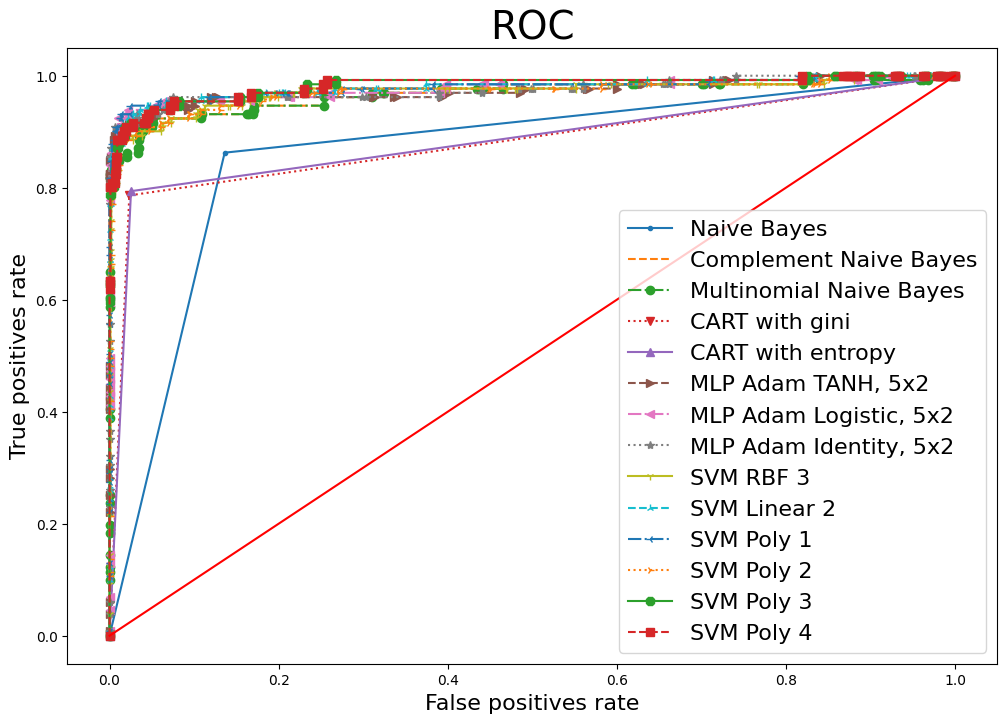

ROC-AUC
----
ROC-AUC for Naive Bayes: 0.8632082790293552
ROC-AUC for Complement Naive Bayes: 0.9673167628622852
ROC-AUC for Multinomial Naive Bayes: 0.9673167628622852
ROC-AUC for CART with gini: 0.8814427791224477
ROC-AUC for CART with entropy: 0.8842433128529759
ROC-AUC for MLP Adam TANH, 5x2: 0.9727471606777137
ROC-AUC for MLP Adam Logistic, 5x2: 0.9769130515732638
ROC-AUC for MLP Adam Identity, 5x2: 0.9756330292310557
ROC-AUC for SVM RBF 3: 0.9707611866194997
ROC-AUC for SVM Linear 2: 0.9792752746229753
ROC-AUC for SVM Poly 1: 0.9795972196363185
ROC-AUC for SVM Poly 2: 0.9705594861292125
ROC-AUC for SVM Poly 3: 0.9818935021411284
ROC-AUC for SVM Poly 4: 0.9820796872090859


In [14]:
#plotting ROC
import matplotlib.pyplot as plt
import seaborn as sns

markers = ['.', ',', 'o', 'v', '^', '>', '<', '*', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', 'H', '+', 'x', '|', '_', '_', 'x','1', '2', '3','.', ',', 'o', 'v', '^', '>','8', 's', 'p', 'P', 'h', 'H', '+', 'x', '|', '_', '_', 'x','1']
lines = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':' ,'-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':'  ]

plt.figure(figsize=(12,8))
for i in range(len(names)):
  plt.plot(FPR[i], TPR[i], label=names[i], marker=markers[i], linestyle=lines[i])

#plotting reference line
sns.lineplot(x = [0, 1], y = [0, 1], color = 'red')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.xlabel('False positives rate',fontsize=16)
plt.ylabel('True positives rate',fontsize=16)
plt.title('ROC', fontsize=28)
plt.legend(fontsize=16, loc=4)
plt.show()

#printing AUC
print('ROC-AUC')
print('----')
for i in range(len(names)):
  print(f'ROC-AUC for {names[i]}: {roc_auc_score(y_test, y_scores[i])}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


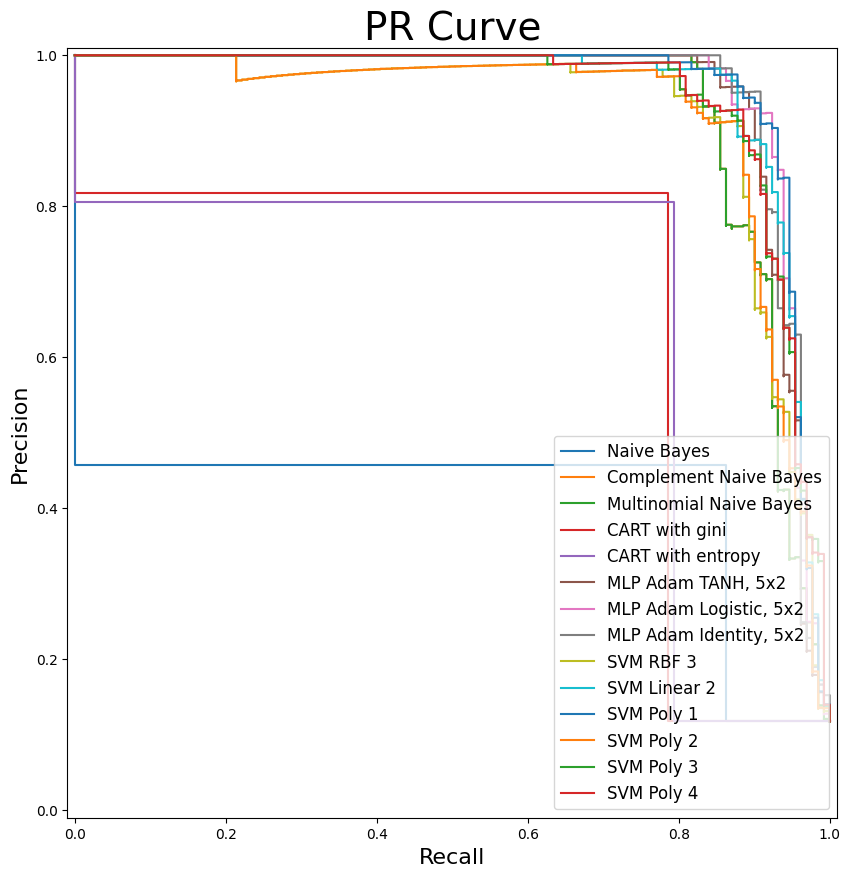

In [15]:
#plotting precision-recall curve
plt.figure(figsize=(12,10))
displays = []
i = 0

y_test = pd.Categorical(y_test)
y_true= y_test.codes

for name, model in models:
  precisionCurve, recallCurve, _ = precision_recall_curve(y_true, y_scores[i])
  displays.append(PrecisionRecallDisplay(precision=precisionCurve, recall=recallCurve, estimator_name=name))
  displays[i].plot(ax=plt.gca())
  i = i + 1



plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.title('PR Curve', fontsize=28)
plt.legend(fontsize=12, loc=4)
plt.show()


In [16]:
def preprocess_text(text):
    # Normalization
    text = str(text)
    text = text.lower()
    # removing punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Removes newlines
    text = re.sub("\n", '', text)
    # digits
    text = re.sub("\d", '', text)

    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Rejoin tokens into a single string
    processed_text = ' '.join(tokens)
    return processed_text

def predict_spam(input_text):

    texts = []

    preds_formart = {}

    for text in input_text:

    # Preprocess the new text
      processed_text = preprocess_text(text)

    # Convert the processed text into a sequence for the model
      sequence = tfidf_vectorizer.transform([processed_text])

    # Use the trained model to predict
      texts.append(sequence)

    for name,model in models:
      predictions = []
      for text in texts:
        try:
          prediction = model.predict(text)
        except (ValueError,TypeError):
          prediction = model.predict(text.toarray())  # Make sure to use your trained model

        #print(name,prediction[0])
        predictions.append(prediction[0])
      preds_formart[name] = predictions
      # Output the result
    # if 'ham' in prediction:
    #     return "Not Spam"
    # else:
    #     return "Spam"
    return preds_formart

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:10: DeprecationWarning: invalid escape sequence '\d'
<>:10: DeprecationWarning: invalid escape sequence '\d'
<ipython-input-16-f545a50ac160>:10: DeprecationWarning: invalid escape sequence '\d'
  text = re.sub("\d", '', text)


In [17]:
# Example of using the function
new_message = ["Congratulations! You've won a free ticket.",
               'Free trip to Hawaii!!',
               "Hi!, it's mom, just checking on you",
               'This is your confirmation of the purchase #2343',
               "Hi, I'm George, thanks for inviting us!",
               'Happy Birthday, Max! See you on monday',
               'Account restoration',
               'Wanna go for a coffe']
result = predict_spam(new_message)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
tests = pd.DataFrame.from_dict(result)
tests['labels'] = pd.Series(['SPAM','SPAM','HAM','SPAM','HAM','HAM','SPAM','HAM'])
tests.index = new_message
tests

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Naive Bayes,Complement Naive Bayes,Multinomial Naive Bayes,CART with gini,CART with entropy,"MLP Adam TANH, 5x2","MLP Adam Logistic, 5x2","MLP Adam Identity, 5x2",SVM RBF 3,SVM Linear 2,SVM Poly 1,SVM Poly 2,SVM Poly 3,SVM Poly 4,labels
Congratulations! You've won a free ticket.,spam,spam,ham,ham,ham,ham,spam,spam,ham,spam,ham,ham,ham,ham,SPAM
Free trip to Hawaii!!,spam,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,SPAM
"Hi!, it's mom, just checking on you",ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,HAM
This is your confirmation of the purchase #2343,spam,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,SPAM
"Hi, I'm George, thanks for inviting us!",spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,HAM
"Happy Birthday, Max! See you on monday",ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,HAM
Account restoration,spam,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,SPAM
Wanna go for a coffe,spam,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,ham,HAM
